In [2]:
import os
from pathlib import Path
import numpy as np
import torch
import pandas as pd
pd.set_option("display.expand_frame_repr", False)
import matplotlib.pyplot as plt

from scatspectra.frontend import (
    load_data,
    analyze,
    generate,
    plot_raw,
    plot_dashboard,
    plot_marginal_moments,
    plot_phase_envelope_spectrum,
)
from scatspectra.data_source import SPDaily, SPVIXDaily
from scatspectra.layers.filter_bank import init_band_pass, init_low_pass
from scatspectra.layers.statistics import TimeAverage, AvgPooling, WindowSelector

CACHE_PATH = Path(os.getcwd()) / "_cache"
CACHE_PATH.mkdir(exist_ok=True)
CUDA = torch.cuda.is_available()

if not CUDA:
    print("CUDA is not available: some computations will be slowed-down")

# Quick start

Model fbm: using cache directory fbm_B64_T6063_H5_0e_01.


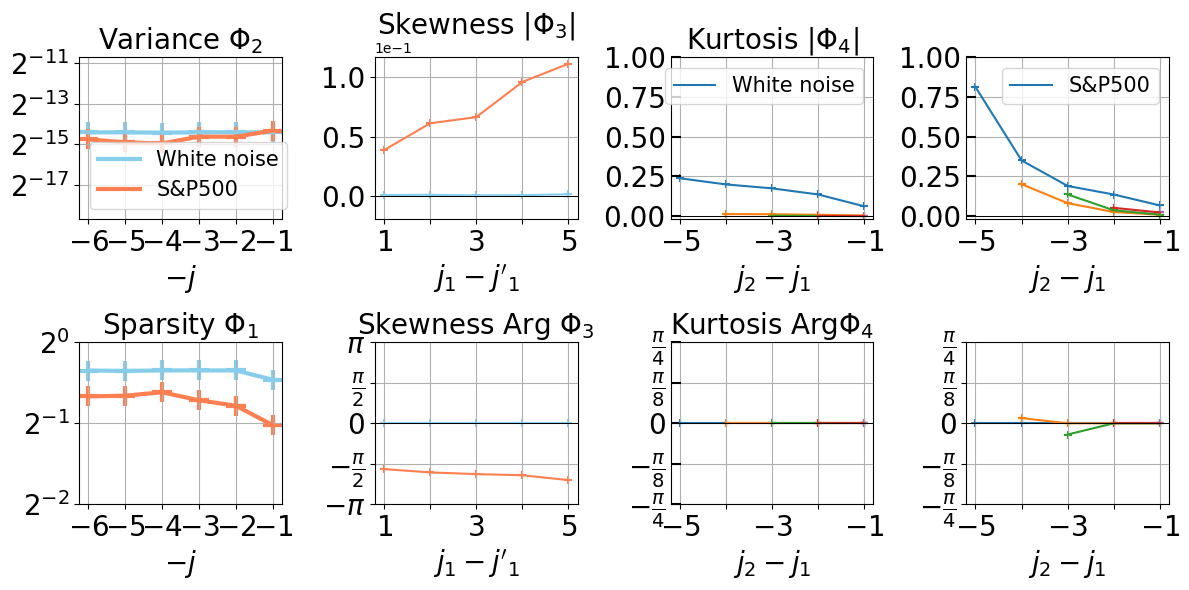

In [2]:
# analyze time-series

# data: snp vs white noise (Black-Scholes model)
data_snp = SPDaily()

x_brownian = load_data(
    name="fbm",
    R=128,
    T=6063,  # 1 realization of 6063 time-steps
    H=0.5,  # Hurst exponent, 0.5 for Brownian motion
    cache_path=CACHE_PATH,
)
dx_brownian = np.diff(x_brownian, axis=-1)

# Scattering Spectra of S&500
scat_snp = analyze(
    x=data_snp.dlnx,
    model_type="scat_spectra",
    J=6,  # number of scales (see next cells)
)

# Scattering Spectra of white noise: for comparison
scat_wn = analyze(
    x=dx_brownian,
    model_type="scat_spectra",
    J=6,  # number of scales (see next cells)
)

axes = plot_dashboard(
    [scat_wn, scat_snp],
    labels=["White noise", "S&P500"],
    theta_threshold=[0.005, 0.1],  # avoid complex-phase instabilities
    figsize=(12, 6),
)
for ax in [axes[0, 1], axes[1, 0]]:
    ax.legend().remove()

Initialize model
Model scat_spectra based on 239 statistics: 
 ---- mean : 1
 ---- spars : 9
 ---- variance : 10
 ---- skewness : 54
 ---- kurtosis : 165
Preparing target statistics
     3it in 0:00:00.34 ( 8.77 it/s ) .... err 2.42E-01
    16it in 0:00:00.65 ( 24.61 it/s ) .... err 1.04E-01
    92it in 0:00:02.57 ( 35.85 it/s ) .... err 2.29E-02
Optimization Exit Message : SmallEnoughException
matched statistics in 6.18s, 235 iterations -- 38.00it/s
    abs sqrt error 5.97E-03
    relative gradient error 3.51E-04
    loss0 2.09E-01


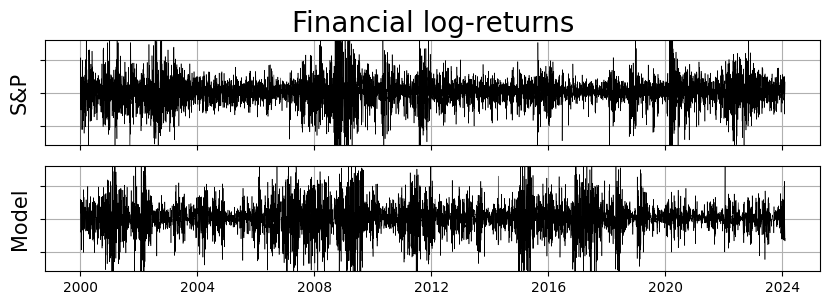

In [2]:
# generate time-series 

# observed data
data_snp = SPDaily()

# generate data
gen_data = generate(
    x=data_snp,
    R=1,  # number of realizations to generate 
    model_type="scat_spectra",
    tol_optim=6e-3,
    cache_path=None,  # provide a directory if you want to cache the generations
    cuda=CUDA,  # you are strongly encouraged to use GPU if available
)

fig, axes = plt.subplots(2, 1, figsize=(10, 3))
axes[0].set_title("Financial log-returns", fontsize=20)
axes[0].plot(data_snp.dts[:-1], data_snp.dlnx[0, 0, :], lw=0.4, color="black")
axes[0].set_ylabel(f"S&P", fontsize=15)
axes[1].plot(data_snp.dts[:-1], gen_data.dlnx[0, 0, :], lw=0.4, color="black")
axes[1].set_ylabel(f"Model", fontsize=15)
for iax, ax in enumerate(axes):
    if iax < axes.size - 1:
        ax.set_xticklabels([])
    ylim = 0.04
    ax.set_ylim(-ylim, ylim)
    ax.grid(True)
    ax.set_yticklabels([])

# 1. Analysis of time-series

This section shows how to use the scattering spectra 


### Data

Model fbm: using cache directory fbm_B64_T6063_H5_0e_01.
Model MRW: using cache directory MRW_B64_T6063_L6063_H5_0e_01_la2_0e_01.


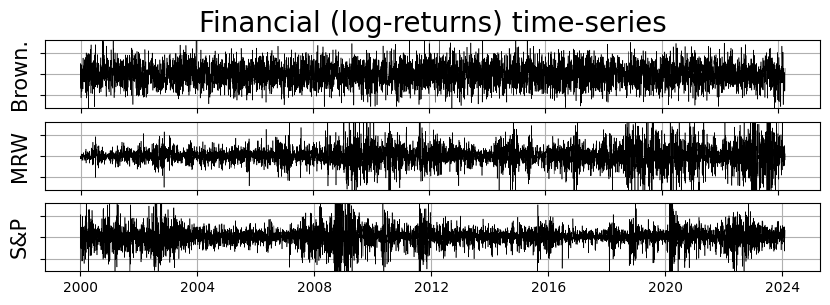

In [4]:
# the function "load_data" provides data from standard models as well as historical data of SP500

# Brownian motion
x_brownian = load_data(
    name="fbm",
    R=128,
    T=6063,  # 1 realization of 6063 time-steps
    H=0.5,  # Hurst exponent, 0.5 for Brownian motion
    cache_path=CACHE_PATH,
)
dx_brownian = np.diff(x_brownian, axis=-1)

# Multifractal Random Walk
x_mrw = load_data(
    name="mrw",
    R=128,
    T=6063,
    H=0.5,  # means no auto-correlation
    lam=0.2,
    cache_path=CACHE_PATH,
)
dx_mrw = np.diff(x_mrw, axis=-1)

# historical daily prices of SP500 from 03-01-2000 to 07-02-2024
data_snp = SPDaily()  # single time-series

################ plotting ####################################
fig, axes = plt.subplots(3, 1, figsize=(10, 3))
axes[0].set_title("Financial (log-returns) time-series", fontsize=20)
axes[0].plot(dx_brownian[0, 0, :], lw=0.4, color="black")
axes[0].set_xticklabels([])
axes[0].set_ylabel(f"Brown.", fontsize=15)
axes[1].plot(dx_mrw[0, 0, :], lw=0.4, color="black")
axes[1].set_xticklabels([])
axes[1].set_ylabel(f"MRW", fontsize=15)
axes[2].plot(data_snp.dts[:-1], data_snp.dlnx[0, 0, :], lw=0.4, color="black")
axes[2].set_ylabel(f"S&P", fontsize=15)
for ax in axes:
    ylim = 0.04
    ax.set_ylim(-ylim, ylim)
    ax.grid(True)
    ax.set_yticklabels([])

### Computation

The function 'analyze' is used to compute the scattering spectra (among other statistics)

Row visualization of Scattering Spectra.
See 'Visualization' for a better visualization.


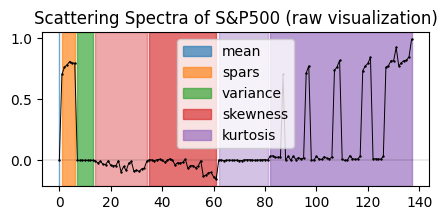

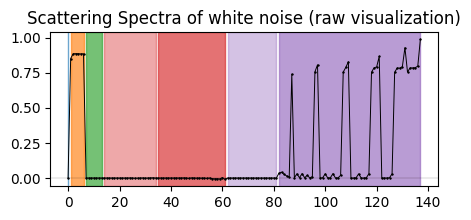

In [5]:
# function 'analyze' computes wavelet-based statistics, e.g. Scattering Spectra:

# Scattering Spectra of S&500
scat_snp = analyze(
    x=data_snp.dlnx,
    model_type="scat_spectra",
    J=6,  # number of scales (see next cells)
)

# Scattering Spectra of white noise: for comparison
scat_wn = analyze(
    x=dx_brownian,
    model_type="scat_spectra",
    J=6,  # number of scales (see next cells)
)

################ plotting ####################################
# quick plot
print("Row visualization of Scattering Spectra.")
print("See 'Visualization' for a better visualization.")
ax1, _ = plot_raw(scat_snp, legend=True)
ax1.set_title("Scattering Spectra of S&P500 (raw visualization)", fontsize=12)
ax2, _ = plot_raw(scat_wn, legend=False)
ax2.set_title("Scattering Spectra of white noise (raw visualization)", fontsize=12);

In [6]:
# some useful methods. See class DescribedTensor for more methods
print(f"Scattering Spectra shape: \n{scat_snp.y.shape} \n")  # batch_size x num_coeffs x num_times (num_times=1 because time has been averaged)
print(f"Scattering Spectra description shape: \n{scat_snp.df.shape}\n")

# Each coefficient scat_snp.y[:,i,:] is described by the row scat_snp.df.iloc[i]
# For example:
i = 15
print(f"Coefficient {i} is equal to \n{scat_snp.y[0,i,0]:.3f}\nand its description is \n\n{scat_snp.df.iloc[i]}\n")

# some additional information
# 'coeff_type': the coefficient type e.g. spars, variance, skewness, kurtosis
# 'nl': (for multi-variate analysis) the in-channel index of the left-term in a correlation
# 'nr': (for multi-variate analysis) the in-channel index of the right-term in a correlation
# 'q': the order of the moment: 1 for the mean or sparsity factors, 2 for the correlation coefficients (variance, skewness, kurtosis)
# 'rl': the scattering order (number of convolutions) of the left-hand term in a correlation
# 'rr': the scattering order (number of convolutions) of the right-hand term in a correlation
# 'scl': the unique scattering index of the scale path (jl1,j2) of the left-hand term in a correlation
# 'scr': the unique scattering index of the scale path (jr1,j2) of the right-hand term in a correlation
# 'jl1': the scale index of the first wavelet of the left-hand term in a correlation
# 'jr1': the scale index of the first wavelet of the right-hand term in a correlation
# 'j2': the scale index of the second wavelet in a correlation
# 'al': (for image data) the angle of the first wavelet of the left-hand term in a correlation
# 'ar': (for image data) the angle of the first wavelet of the right-hand term in a correlation
# 'is_low': whether this is a low-pass coefficient: the last wavelet corresponds to a low-pass filter

# to access coefficients by their description:
# for example, accessing a skewness coefficients at scale j=2
print("Coefficient selection")
selected_coeff = scat_snp.query(
    coeff_type="skewness", jl1=2, jr1=2
)  # DescribedTensor object
print(selected_coeff.df)
print(selected_coeff.y[0, 0, 0].item(), "\n")
# other example: selecting the sparsity and variance coefficients
selected_coeff = scat_snp.query(coeff_type=["spars", "variance"])
print(selected_coeff.df)
print(selected_coeff.y[0, :, 0])

Scattering Spectra shape: 
torch.Size([1, 97, 1]) 

Scattering Spectra description shape: 
(97, 15)

Coefficient 15 is equal to 
0.003-0.022j
and its description is 

coeff_type    skewness
is_real          False
nl                   0
nr                   0
q                    2
rl                   1
rr                   2
scl                  1
scr                  8
jl1                  1
jr1                  0
j2                   1
al                   0
ar                   0
is_low           False
Name: 1, dtype: object

Coefficient selection
  coeff_type  is_real  nl  nr  q  rl rr  scl scr jl1 jr1 j2  al ar  is_low
5   skewness    False   0   0  2   1  2    2  20   2   2  2   0  0   False
(0.0005035312084437973-0.00387997137572426j) 

  coeff_type  is_real  nl  nr  q  rl    rr  scl   scr jl1   jr1    j2  al    ar  is_low
0      spars     True   0   0  1   1  <NA>    0  <NA>   0  <NA>   NaN   0  <NA>   False
1      spars     True   0   0  1   1  <NA>    1  <NA>   1  <NA>   NaN

### Visualization

For a Scattering Spectra representation, function "plot_dashboard" separates the different coefficients \
and visualize them as 'spectra', as curves along scales.
- 'mean' (1 coeff): the time-average of x: $<x(t)>_t$
- 'spars' (~J coeffs): the sparsity factor of wavelet coefficients at each scale: $<|x\star\psi_j(t)|>_t / \sigma_j$
- 'variance' (~J coeffs): the variance, or energy, of wavelet coefficients at each scale: $\sigma^2_j = <|x\star\psi_j(t)|^2>_t$
- 'skewness' (~J^2/2 coeffs): the cross-scale correlations $<x\star\psi_{j_l}(t)~|x\star\psi_{j_r}(t)|> / (\sigma_{j_l} \sigma_{j_r})$
- 'kurtosis' (~J^3/6 coeffs): the cross-scale correlations $<|x\star\psi_{j_l}|*\psi_{j_2}(t)~|x\star\psi_{j_r}(t)|\star\psi^*_{j_2}(t)> / (\sigma_{j_l} \sigma_{j_r})$

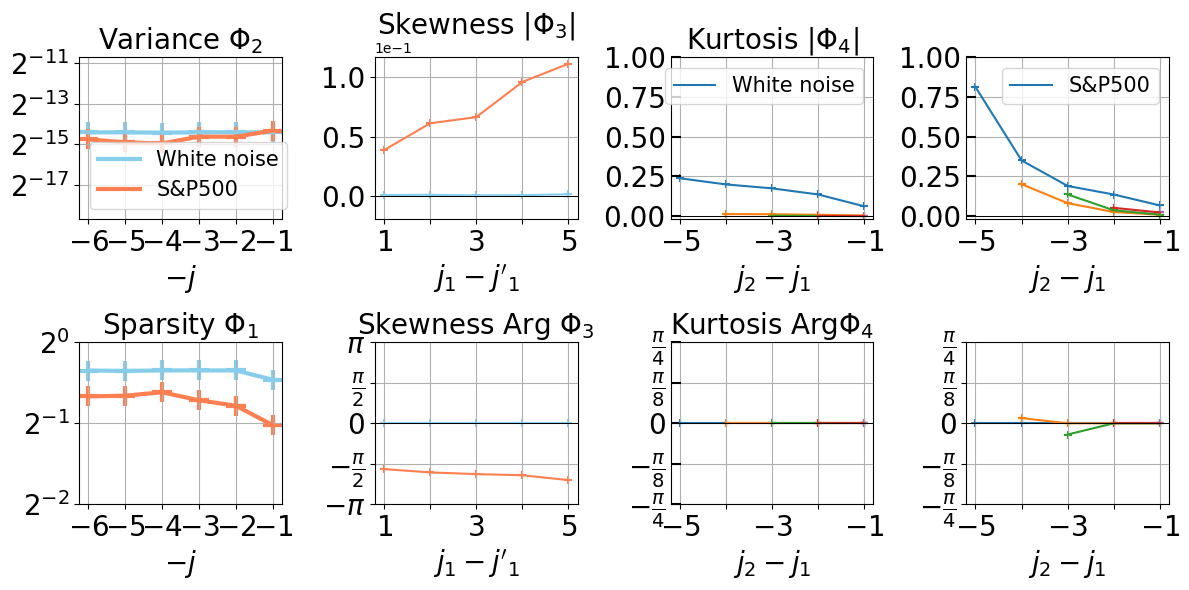

In [11]:
axes = plot_dashboard(
    [scat_wn, scat_snp],
    labels=["White noise", "S&P500"],
    theta_threshold=[0.005, 0.1],  # avoid complex-phase instabilities
    figsize=(12, 6),
)
for ax in [axes[0, 1], axes[1, 0]]:
    ax.legend().remove()

### Interpretation

Can be found in the paper "Scale Dependencies and Self-Similar Models with Wavelet Scattering Spectra" https://arxiv.org/abs/2204.10177

#### sparsity $\Phi_1$, variance $\Phi_2$

'variance' coefficients: the standard power spectrum $\sigma^2_j = <|x\star\psi_j(t)|^2>_t$
\
The power-spectrum of both white noise and S&P500 is flat, as expected:
these time-series are uncorrelated over time.

'sparsity' coefficients: sparsity at different scales $<|x\star\psi_j(t)|>_t / \sigma_j$
\
The level and decay of the curve quantifies intermittency: the lower and the steeper
the curve, the more sparsity. \
For a Gaussian, this curve is flat, at a high level. 
For a financial time-series which presents intermittency, e.g. crisis, 
this curve is low and decreases.

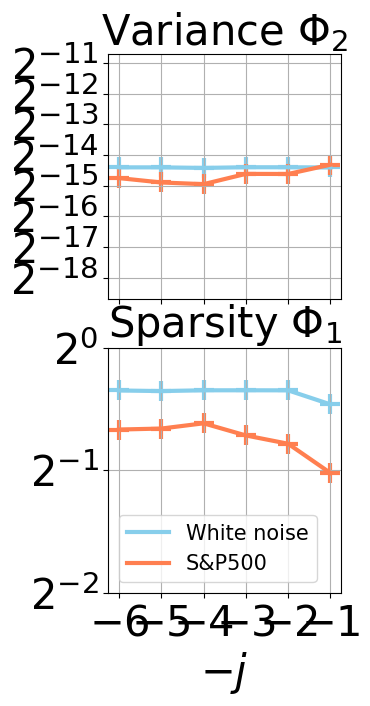

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(3, 7))
plot_marginal_moments([scat_wn, scat_snp], labels=["White noise", "S&P500"], axes=axes)
axes[0].set_xticklabels([])
axes[0].set_xlabel((""))
axes[0].legend().remove()

#### skewness $\Phi_3$

Skewness coefficients: $<x\star\psi_{j_l}(t)~|x\star\psi_{j_r}(t)|> / (\sigma_{j_l} \sigma_{j_r})$

Their modulus quantify the change in $x$ when its sign is changed $-x$. \
A 'skewed' process breaks the sign invariance $x$-> $-x$. \
The larger their modulus the more 'skewed' the process is.

Their complex-phase quantifies time-asymmetry that is the change in the \
process $x$ when the time is reversed $x(-t)$. \
A non-zero phase indicates time-asymmetry.

A Gaussian process is invariant to sign-change and time-reversal, thus, both 
curves are zero. 

The financial time-series is skewed as shown on the graph of $\Phi_3$. \
It has also time-asymmetries, as shown on the graph of Arg $\Phi_3$. \ 
Both are expected -- this is the leverage effect.

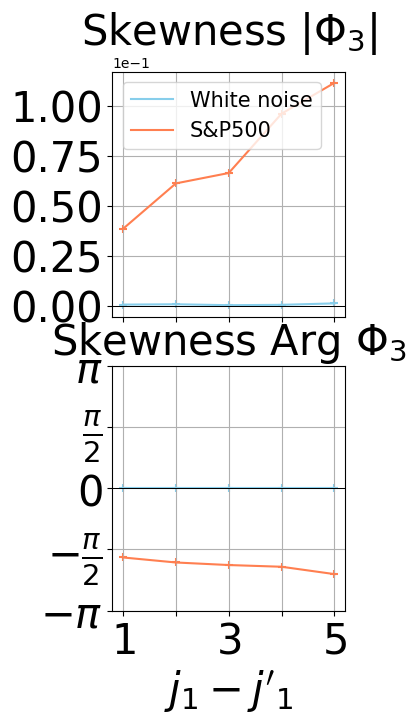

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(3, 7))
plot_phase_envelope_spectrum(
    [scat_wn, scat_snp], labels=["White noise", "S&P500"], axes=axes, theta_threshold=0.005
)
axes[0].set_xticklabels([])
axes[0].set_xlabel((""));

## Additional features

### Changing the averaging operator

Scattering Spectra are estimated by averaging over the time dimension. \
Other operators are available such as average pooling. \
They can be provided through the 'estim_operator' argument in 'analyze' function. 

In [14]:
# default: Scattering Spectra statistics averaged on the full window
estim_operator = None
scat_wn = analyze(
    x=np.random.randn(1024),
    model_type="scat_spectra",
    estim_operator=None,
)
print("Output time shape", scat_wn.y.shape[-1])

# window selection: Scattering Spectra at each time: no average
window = np.arange(12, 1024 - 12)
estim_operator = WindowSelector(window=window)
scat_wn = analyze(
    x=np.random.randn(1024), model_type="scat_spectra", estim_operator=estim_operator
)
print("Output time shape", scat_wn.y.shape[-1])

# average on a given window e.g. the middle 512 samples
estim_operator = TimeAverage(window=window)
scat_wn = analyze(
    x=np.random.randn(1024), model_type="scat_spectra", estim_operator=estim_operator
)
print("Output time shape", scat_wn.y.shape[-1])

# average pooling
estim_operator = AvgPooling(kernel_size=2, stride=2)
scat_wn = analyze(
    x=np.random.randn(1024), model_type="scat_spectra", estim_operator=estim_operator
)
print("Output time shape", scat_wn.y.shape[-1])

Output time shape 1
Output time shape 1000
Output time shape 1
Output time shape 512


## Choosing the hyper-parameters

Every parameter of 'analyze' admits a default value so that the only parameter
to provide is the data to analyze.

However, if you want to explore changes in the wavelet parameter, 
the generative algorithm etc ... here are some guidelines.

See section "choosing tol_optim" for choosing the only hyperparameter associated to generation.

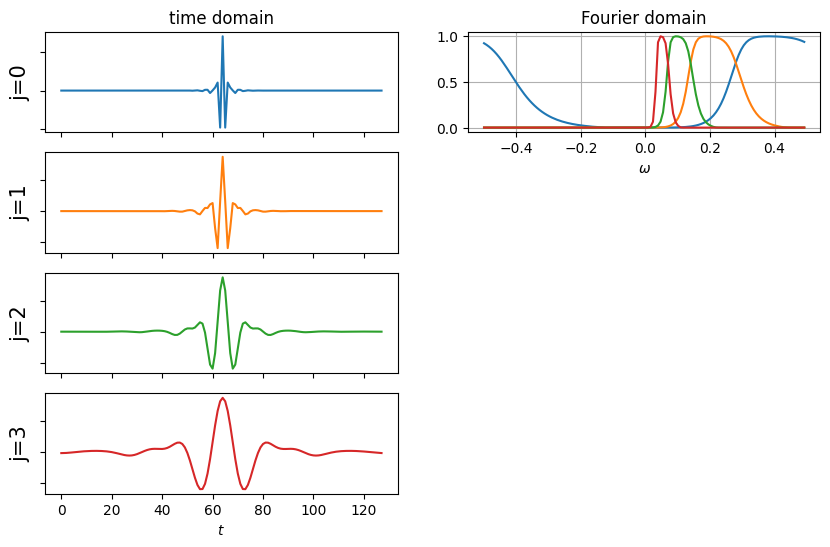

In [15]:
# plotting the wavelet filters


def get_wavelets_psi(T, J, Q, wav_type, high_freq):
    psi_hat = torch.tensor(init_band_pass(wav_type, T, J, Q, high_freq, wav_norm="l1"))
    psi = torch.fft.ifft(psi_hat)
    psi = torch.roll(psi, shifts=(psi.shape[-1]//2,), dims=(-1,))
    return psi, psi_hat


def get_wavelet_phi(T, J, Q, wav_type, high_freq):
    phi_hat = torch.tensor(init_low_pass(wav_type, T, J, Q, high_freq))
    phi = torch.fft.ifft(phi_hat)
    phi = torch.roll(phi, shifts=(phi.shape[-1]//2,), dims=(-1,))
    return phi, phi_hat


T = 128
J = 4

filter, psi_hat = get_wavelets_psi(
    T, J=J, Q=1, wav_type="battle_lemarie", high_freq=0.425
)
freq = torch.fft.fftfreq(T)

################ plotting ####################################
_, axes = plt.subplots(J, 2, figsize=(10, 6))
axes[0, 0].set_title("time domain")
axes[0, 1].set_title("Fourier domain")
axes[0, 1].plot(torch.fft.fftshift(freq), torch.fft.fftshift(psi_hat, dim=-1).real.T)
axes[0, 1].grid(True)
axes[-1, 0].set_xlabel("$t$")
axes[0, 1].set_xlabel("$\omega$")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for j in range(J):
    color = colors[j % len(colors)]
    axes[j, 0].plot(filter[j, :].real, color=color)
    axes[j, 0].set_ylabel(f"j={j}", fontsize=15)
    if j > 0:
        axes[j, 1].remove()
    if j < J - 1:
        axes[j, 0].set_xticklabels([])
    if j < J:
        axes[j, 0].set_yticklabels([])

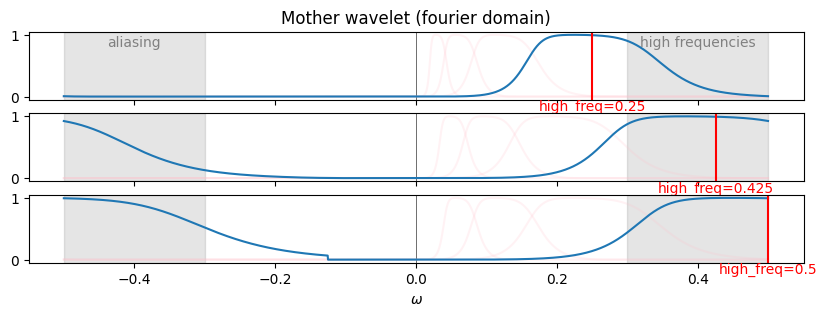

In [16]:
# parameter 'high_freq'
# the central frequency of the mother wavelet
# 0.0 < high_freq < 0.5, default=0.425 for "battle_lemarie" wavelets

# the choice of high_freq is ruled by the following trade-off
# 1. the energy of the mother wavelet on negative frequencies should be
# as small as possible (because this breaks the fact that other band-pass filters
# are obtained by dilation)
# 2. the mother wavelet should cover high-frequency (omega~<0.5)

# we consistently take high_freq=0.425 for battle-lemarie wavelets:
# below:
# high_freq=0.25: high-frequencies are partially covered
# high_freq=0.425: small aliasing and high-frequencies are covered
# high_freq=0.5: too much aliasing

T = 2048

high_freqs = [0.25, 0.425, 0.5]
psis_hat = [
    get_wavelets_psi(T, J=8-4, Q=1, wav_type="battle_lemarie", high_freq=high_freq)[1]
    for high_freq in high_freqs
]
freqs = torch.fft.fftfreq(T)

################ plotting ####################################
fig, axes = plt.subplots(len(high_freqs), 1, figsize=(10, 3))
axes[0].set_title("Mother wavelet (fourier domain)")
axes[-1].set_xlabel("$\omega$")
axes[0].text(
    -0.4,
    0.95,
    "aliasing",
    color="gray",
    transform=axes[0].get_xaxis_transform(),
    ha="center",
    va="top",
)
axes[0].text(
    0.4,
    0.95,
    "high frequencies",
    color="gray",
    transform=axes[0].get_xaxis_transform(),
    ha="center",
    va="top",
)
for i in range(len(high_freqs)):
    if i < 2:
        axes[i].set_xticklabels([])
    axes[i].axvline(0.0, color="black", lw=0.4)
    axes[i].plot(
        torch.fft.fftshift(freqs),
        torch.fft.fftshift(psis_hat[i][1:, :], dim=-1).real.T,
        color="pink",
        alpha=0.2,
    )
    axes[i].plot(
        torch.fft.fftshift(freqs),
        torch.fft.fftshift(psis_hat[i][0, :], dim=-1).real,
        label=f"high_freq={high_freqs[i]}",
    )
    axes[i].axvline(high_freqs[i], color="red")
    axes[i].text(
        high_freqs[i],
        0.0,
        f"high_freq={high_freqs[i]}",
        color="red",
        transform=axes[i].get_xaxis_transform(),
        ha="center",
        va="top",
    )
    axes[i].axvspan(-0.5, -0.3, color="black", alpha=0.1)
    axes[i].axvspan(0.3, 0.5, color="black", alpha=0.1)

tensor(323)
tensor(647)
tensor(1528)


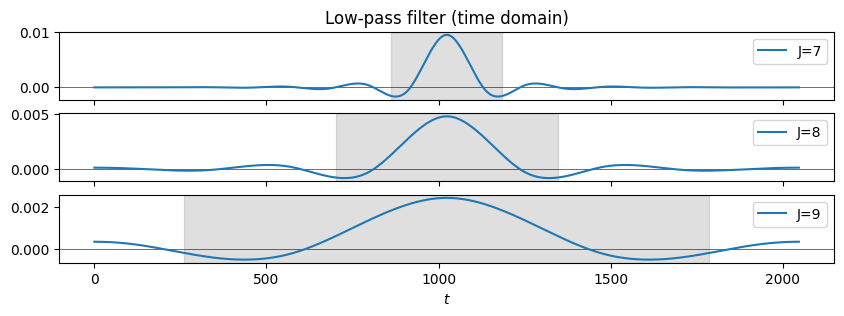

In [17]:
# parameter 'J'
# the number of scales
# 1 < J, default~=log_2(T)-3 for "battle_lemarie" wavelets

# the choice of J is ruled by a tradeoff
# 1. J should be large enough for the model to capture long-range dependencies
# 2. J should be small enough for the largest-scale coefficients to be well-estimated

# below:
# J = log_2(T)-4: the low-pass wavelet support is of the order of 12% of the
#       time-series size: long-range dependencies, if any, won't be captured well
# J = log_2(T)-3: the low-pass wavelet support is of the order of 25%.
#       Intuitively, the average <|x*\phi(t)|^2> is thus made on 4 points.
#       (Number of non-overlapping support intervals that can put on the time-series).
# J = log_2(T)-2: the low-pass wavelet support is of the order of 50%.
#       Intuitively, the average <|x*\phi(t)|^2> is made on 2 points, which
#       yields a large-variance estimator.

T = 2048


def get_support_size(filter, threshold=0.10):
    threshold = filter.abs().max() * threshold
    size = (filter.abs() > threshold).sum(-1)
    idx_max = filter.abs().argmax(-1)
    idces = torch.arange(idx_max - size // 2, idx_max + size // 2)
    return size, idces


J_choosen = int(np.log2(T)) - 3
Js = [J_choosen - 1, J_choosen, J_choosen + 1]
phis = [
    get_wavelet_phi(T, J=J, Q=1, wav_type="battle_lemarie", high_freq=0.425)[0]
    for J in Js
]
freqs = torch.fft.fftfreq(T)

################ plotting ####################################
fig, axes = plt.subplots(len(Js), 1, figsize=(10, 3))
axes[0].set_title("Low-pass filter (time domain)")
axes[-1].set_xlabel("$t$")
for i in range(len(Js)):
    axes[i].axhline(0.0, color="black", lw=0.4)
    s, idces = get_support_size(phis[i])
    print(s)
    axes[i].axvspan(idces.min(), idces.max(), color="gray", alpha=0.25)
    if i < 2:
        axes[i].set_xticklabels([])
    axes[i].plot(phis[i].real, label=f"J={Js[i]}")
    axes[i].legend()

/tmp/ipykernel_4161908/100696884.py:40: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  torch.fft.fftshift(wav_hat, dim=-1).real.T,


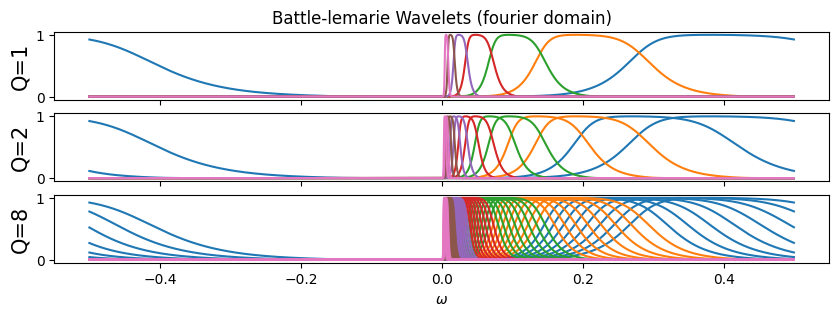

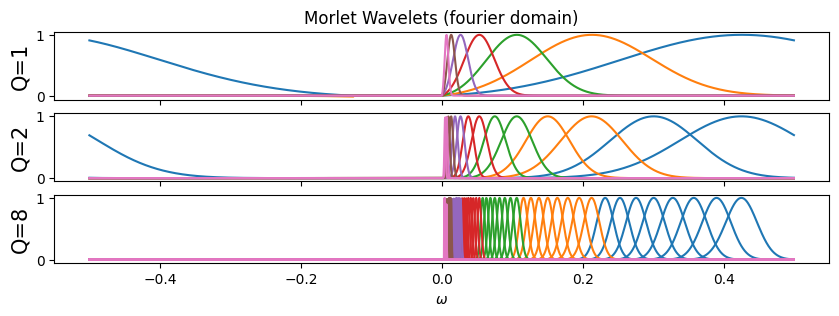

In [18]:
# parameter 'Q'
# the number of wavelets per scale
# 1 <= Q, default=1

# increasing Q has the following behavior depending on the wavelet
# 1. for "battle_lemarie" wavelets, increasing Q will introduce intermediate
# dilation steps: 2^(j/Q) from one filter to the other
# 2. for "morlet" wavelets, increasing Q increases the frequency resolution of
# each wavelet
# (these two separate behaviors has nothing to do with the type of wavelet,
# they are just a code artefact)

# take Q>1 (with "morlet" wavelets) only if the time-series has non-trivial
# structures which require better frequency resolution to be characterized

T = 2048

J = int(np.log2(T)) - 4
Qs = [1, 2, 8]
psis_hat_bl = [
    get_wavelets_psi(T, J=J, Q=Q, wav_type="battle_lemarie", high_freq=0.425)[1]
    for Q in Qs
]
psis_hat_morlet = [
    get_wavelets_psi(T, J=J, Q=Q, wav_type="morlet", high_freq=0.425)[1] for Q in Qs
]
freqs = torch.fft.fftfreq(T)

################ plotting ####################################
fig, axes = plt.subplots(len(Qs), 1, figsize=(10, 3))
axes[0].set_title("Battle-lemarie Wavelets (fourier domain)")
axes[-1].set_xlabel("$\omega$")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for i in range(len(Qs)):
    if i < 2:
        axes[i].set_xticklabels([])
    for j, wav_hat in enumerate(psis_hat_bl[i]):
        axes[i].plot(
            torch.fft.fftshift(freqs),
            torch.fft.fftshift(wav_hat, dim=-1).real.T,
            color=colors[j // Qs[i]],
        )
    axes[i].set_ylabel(f"Q={Qs[i]}", fontsize=15)
fig, axes = plt.subplots(len(Qs), 1, figsize=(10, 3))
axes[0].set_title("Morlet Wavelets (fourier domain)")
axes[-1].set_xlabel("$\omega$")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for i in range(len(Qs)):
    if i < 2:
        axes[i].set_xticklabels([])
    for j, wav_hat in enumerate(psis_hat_morlet[i]):
        axes[i].plot(
            torch.fft.fftshift(freqs),
            torch.fft.fftshift(wav_hat, dim=-1).real.T,
            color=colors[j // Qs[i]],
        )
    axes[i].set_ylabel(f"Q={Qs[i]}", fontsize=15)

## Applications

### Calibration

While we provide a model based on the scattering spectra (see next section on generation), \
the scattering spectra can be used to calibrate your own model. 

We show a simple example of calibration of a multifractal random walk by fitting the kurtosis coefficients $\Phi_1(x)$. \
Note that for this example, there is only 1 important parameter to fit (intermittency $\lambda$) for which simpler methods exist.

best param: λ=0.21+- 0.01


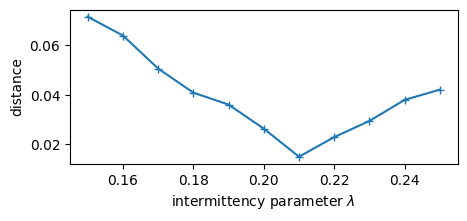

In [19]:
R = 64  # increase the number of MRW realizations to have a better estimation

# historical daily prices of SP500 from 03-01-2000 to 07-02-2024
data_snp = SPDaily()  # single time-series

# the scattering spectra of the S&P500
scat_snp = analyze(
    x=data_snp.dlnx,
    model_type="scat_spectra",
    J=9,
).query(coeff_type="spars").y

# generate MRW time-series with different intermittency parameters \lambda
lams = np.linspace(0.15, 0.25, 11)
x_mrw = [
    load_data(name="mrw", R=R, T=6063, H=0.5, lam=lam, verbose=False)
    for lam in lams
]
x_mrw = np.stack(x_mrw, axis=0)  # nb_lambda x nb_realizations x 1 x nb_times

# the scattering spectra of the MRW for different \lambda
scat_mrw = analyze(
    x=x_mrw.reshape(-1,1,6063),
    model_type="scat_spectra",
    J=9, 
    cuda=CUDA,
).query(coeff_type="spars").y.reshape(len(lams), R, -1, 1).mean(1)

# compute distance in the scattering spectra
distance = (scat_snp - scat_mrw).abs().mean((1,2))
argmin = distance.argmin()
best_lambda = lams[argmin]
print(f"best param: λ={best_lambda:.2f}+- {lams[1]-lams[0]:.2f}")  # the confidence interval is not rigorous

################ plotting ####################################
fig, ax = plt.subplots(1, 1, figsize=(5, 2))
ax.plot(lams, distance, marker='+')
ax.set_xlabel(r"intermittency parameter $\lambda$");
ax.set_ylabel("distance");

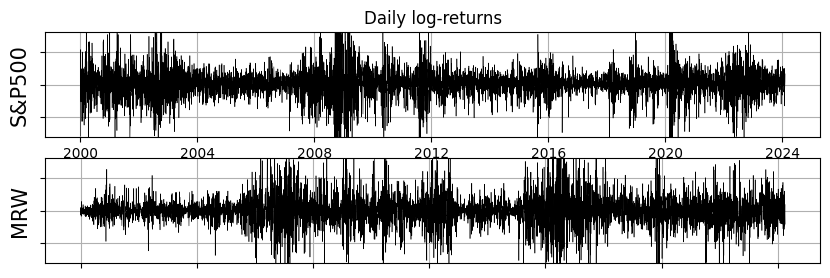

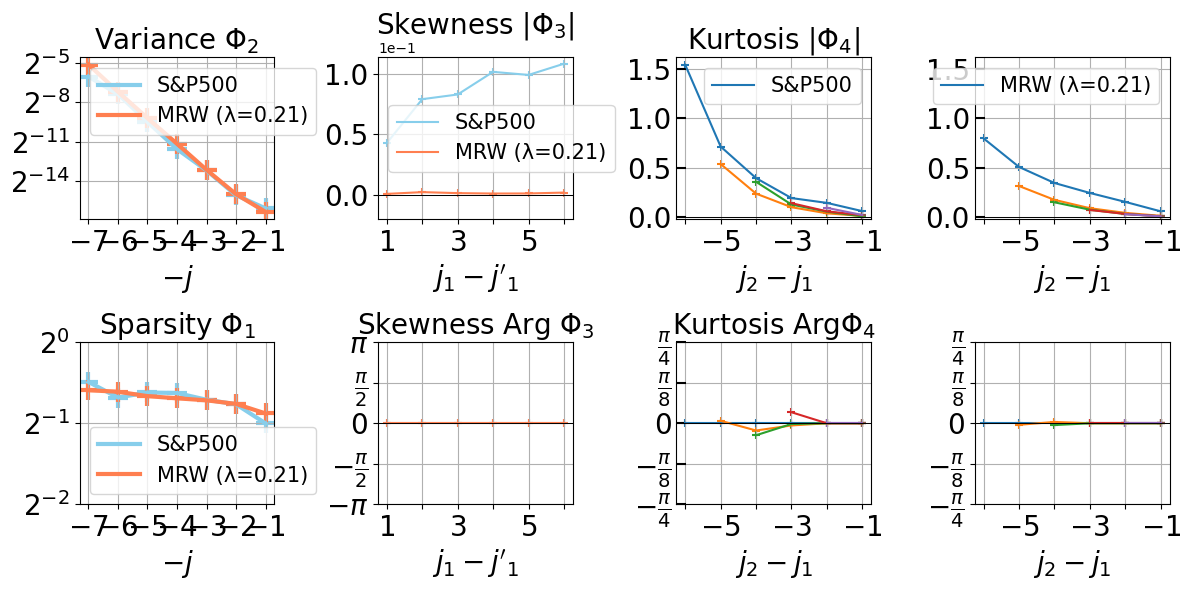

In [20]:
# example of a MRW realization with fitted parameter
fig, axes = plt.subplots(2, 1, figsize=(10, 3))
axes[0].set_title("Daily log-returns")
axes[0].plot(data_snp.dts[:-1], data_snp.dlnx[0,0,:], lw=0.4, color="black")
axes[0].set_ylabel("S&P500", fontsize=15)
axes[1].plot(np.diff(x_mrw[6,0,0,:]), lw=0.4, color="black")
axes[1].set_ylabel("MRW", fontsize=15)
axes[1].set_xticklabels([])
for ax in axes:
    ax.grid(True)
    ax.set_yticklabels([])
    ax.set_ylim(-0.04,0.04)

# visualizing scattering spectra for the best lambda
scat_snp = analyze(
    x=data_snp.lnx,
    model_type="scat_spectra",
    J=7,
)
scat_best_mrw = analyze(
    x=load_data(name="mrw", R=R, T=6063, H=0.5, lam=best_lambda, verbose=False),
    model_type="scat_spectra",
    J=7,
)
plot_dashboard(
    [scat_snp, scat_best_mrw],
    labels=["S&P500", f"MRW (λ={best_lambda:.2f})"],
    theta_threshold=[0.3, 0.1],
    figsize=(12, 6),
);

### Classification of jumps

This section implements a minimal example for analyzing jump time-series.

Based on the paper 

Riding Wavelets: A Method to Discover New Classes of Price Jumps

C. Aubrun*, R. Morel*, M. Benzaquen, J.-P. Bouchaud

https://arxiv.org/pdf/2404.16467

In [7]:
# useful variables / functions
from scatspectra.models import DescribedTensor
from scatspectra import format_to_real

def jump_envelope(a):
    """ Create the envelope of a jump time-series. """

    # parameters
    tc = -0.5
    d = 0.01
    Nl = Nr = 0.1
    p0 = 0.2

    # the power-law exponents on the left/right
    pl, pr = p0 + a, p0 - a

    # assemble the envelope
    env = np.zeros((a.size, ts.size))
    env += Nl * np.abs(ts - tc)[None,:] ** (-pl[:,None]) * (ts < 0)[None,:]
    env += Nr * np.abs(ts - tc)[None,:] ** (-pr[:,None]) * (ts > 0)[None,:]
    env += d
    env[:,ts==0] = 0.5 * (env[:,ts==-1] + env[:,ts==1])   

    return env

def generate_benchmark_jumps(asym, noise_fact, B=1):
    """ Generate a benchmark jump with various volatility asymmetry. """

    # create the noise
    noise = np.random.randn(B, asym.size, ts.size) * noise_fact

    # create the envelopes of the jumps 
    envelopes = jump_envelope(asym)

    x_jumps = envelopes[None,:,:] * noise

    # normalize
    x_jumps -= x_jumps.mean(-1, keepdims=True)
    x_jumps /= x_jumps.std(-1, keepdims=True)

    return x_jumps

def format_description(scat): 
    """ Format the description of a DescribedTensor object. """
    df = scat.df.copy()
    df["c_type"] = [f"r={r}" for r in df.r]
    df["is_real"] = df.is_low
    return DescribedTensor(y=scat.y, df=df)

# the time indices of a jump time-series
ts = np.arange(-59,59+1)

# number of wavelet scales (for scattering coefficients)
J = 6

# reflexivity direction (1st PCA vector, see paper)
pca_asymmetry = np.array([
    0.0019335, -0.14006851, -0.30314096, -0.39374077, -0.39523457,
    -0.05288888, -0.24239903, -0.3734948 , -0.38437223, -0.07060931,
    -0.24865032, -0.31984045, -0.08952533, -0.21337344, -0.07610514
])

# mean-reverting direction
mr_filter = np.zeros(ts.size)
mr_filter[ts==-2] = 0.5
mr_filter[ts==-1] = 1.0
mr_filter[ts==1] = -1.0
mr_filter[ts==2] = -0.5

# trend direction
tr_filter = np.zeros(ts.size)
tr_filter[ts==-2] = 0.5
tr_filter[ts==-1] = 1.0
tr_filter[ts==1] = 1.0
tr_filter[ts==2] = 0.5

def compute_scat_asym(x):
    """ Compute the asymmetry score of a jump time-series. """
    # compute scattering coefficients 'scat'
    signs = np.sign(x[:,ts==0])
    scat = analyze(signs*x, model_type=None, J=6, normalize="each_ps", skew_redundance=False)
    scat = format_description(scat)
    t0 = np.where(ts==0)[0][0]
    scat.y = scat.y[:, :, t0:t0+1]

    # extract second order coefficients Imag(W|Wx|): time-asymmetry of the volatility profile
    scat_im = format_to_real(scat.query(is_low=False))
    scat_im = scat_im.query(is_real=False, r=2)
    scat_im.y = scat_im.y[...,0]

    return scat_im

def compute_reflexivity(scat_x):
    """ Compute the reflexivity score of ajump time-series. """
    y_reflexivity = scat_x.y / (scat_x.y**2).mean(-1, keepdims=True)**0.5
    return (y_reflexivity @ pca_asymmetry).numpy()

def compute_mr_score(x):
    """ Compute the mean-reverting score of a time-series. """
    signs = np.sign(x[...,ts==0])
    return (signs * x) @ mr_filter

def compute_td_score(x):
    """ Compute the trend score of a jump time-series. """
    signs = np.sign(x[...,ts==0])
    return (signs * x) @ tr_filter

Benchmark jumps (16, 32, 119)


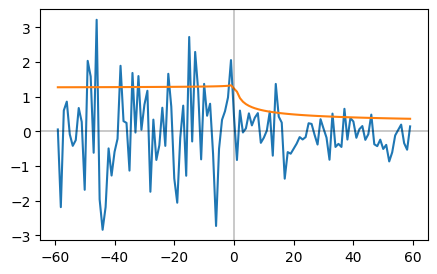

In [8]:
# generate benchmark jumps
B = 16  # batch_size: number of jumps with given asymmetry  # increase B for a better estimation of the benchmark
n_asym_level = 32  # number of asymmetry levels

asym_levels = np.linspace(-0.19, 0.19, n_asym_level)
x_jumps = generate_benchmark_jumps(asym_levels, noise_fact=0.5, B=B)
print(f"Benchmark jumps {x_jumps.shape}")

# visualize the most anticipatory jump
i_plot = 0
envs = jump_envelope(asym_levels)
plt.figure(figsize=(5,3))
plt.plot(ts, x_jumps[0,i_plot,:])
plt.plot(ts, 12*envs[i_plot,:])
plt.axhline(0.0, lw=0.3, color="black")
plt.axvline(0.0, lw=0.3, color="black");

In [9]:
# reflexivity score
# compute scattering coefficients 'scat'
scat_x = compute_scat_asym(x_jumps.reshape(-1,ts.size))

# extract second order coefficients Imag(W|Wx|): time-asymmetry of the volatility profile
y_reflexivity = compute_reflexivity(scat_x)
y_reflexivity = y_reflexivity.reshape(B, -1)
print(f"Reflexivity score: {y_reflexivity.shape}")

Reflexivity score: (16, 32)


In [10]:
# compute mean-reversion score
y_mr = compute_mr_score(x_jumps)
print(f"Mean-reversion score: {y_mr.shape}")

# compute trend score
y_td = compute_td_score(x_jumps)
print(f"Trend score: {y_td.shape}")

Mean-reversion score: (16, 32)
Trend score: (16, 32)


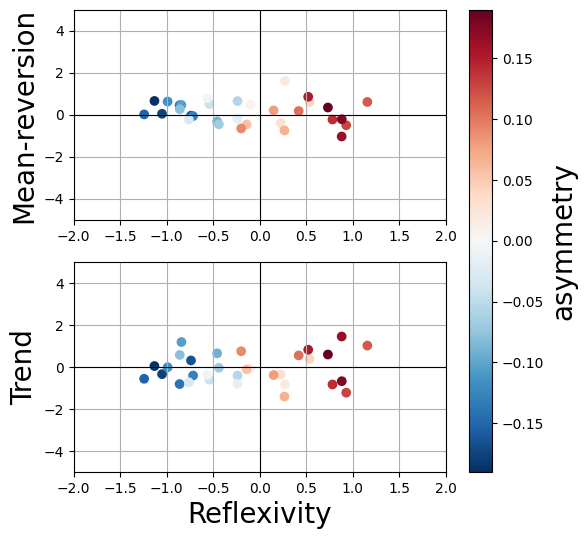

In [11]:
# visualization
fig, axes = plt.subplots(2, 1, figsize=(6, 6))

sc = axes[0].scatter(y_reflexivity.mean(0), y_mr.mean(0), label="Reflexivity score", c=asym_levels, cmap='RdBu_r');
axes[1].scatter(y_reflexivity.mean(0), y_td.mean(0), label="Reflexivity score", c=asym_levels, cmap='RdBu_r');
for ax in axes:
    ax.set_xlim(-2,2)
    ax.set_ylim((-5,5))
    ax.grid(True)
    ax.axhline(0.0, lw=0.8, color='black')
    ax.axvline(0.0, lw=0.8, color='black')
axes[0].set_ylabel("Mean-reversion", fontsize=20)
axes[1].set_ylabel("Trend", fontsize=20)
axes[1].set_xlabel("Reflexivity", fontsize=20)

cbar = fig.colorbar(sc, ax=axes, orientation='vertical', label='asymmetry')
cbar.set_label('asymmetry', size=20);

# 2. Generation of time-series

### Choosing 'tol_optim'

The tolerance optimization: threshold \epsilon used to assess the moment matching \
between observed data and generated data:

$$ \| \phi(x_\text{observed}) - \phi(x_\text{generated}) \| < \epsilon$$

This parameter should be gradually increased until we can observe certain  \
mismatch between $\phi(x_\text{observed})$ and $\phi(x_\text{generated})$ (see below example). \
In general, the algorithm would have to run for 100 to 5000 iterations. 

Initialize model
Model scat_spectra based on 239 statistics: 
 ---- mean : 1
 ---- spars : 9
 ---- variance : 10
 ---- skewness : 54
 ---- kurtosis : 165
Preparing target statistics
     4it in 0:00:00.16 ( 24.79 it/s ) .... err 1.72E-01
    12it in 0:00:00.37 ( 32.20 it/s ) .... err 1.10E-01
Optimization Exit Message : SmallEnoughException
matched statistics in 1.34s, 49 iterations -- 36.48it/s
    abs sqrt error 4.93E-02
    relative gradient error 6.24E-03
    loss0 1.88E-01


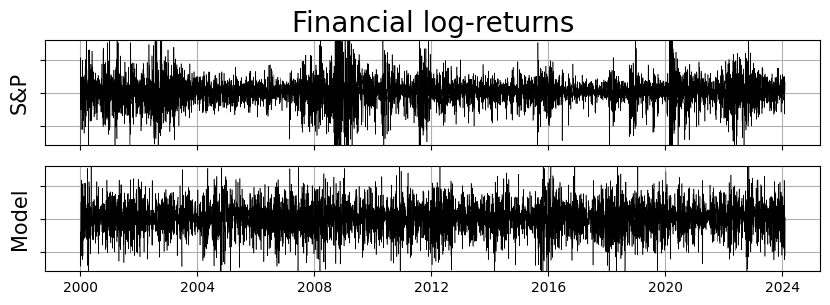

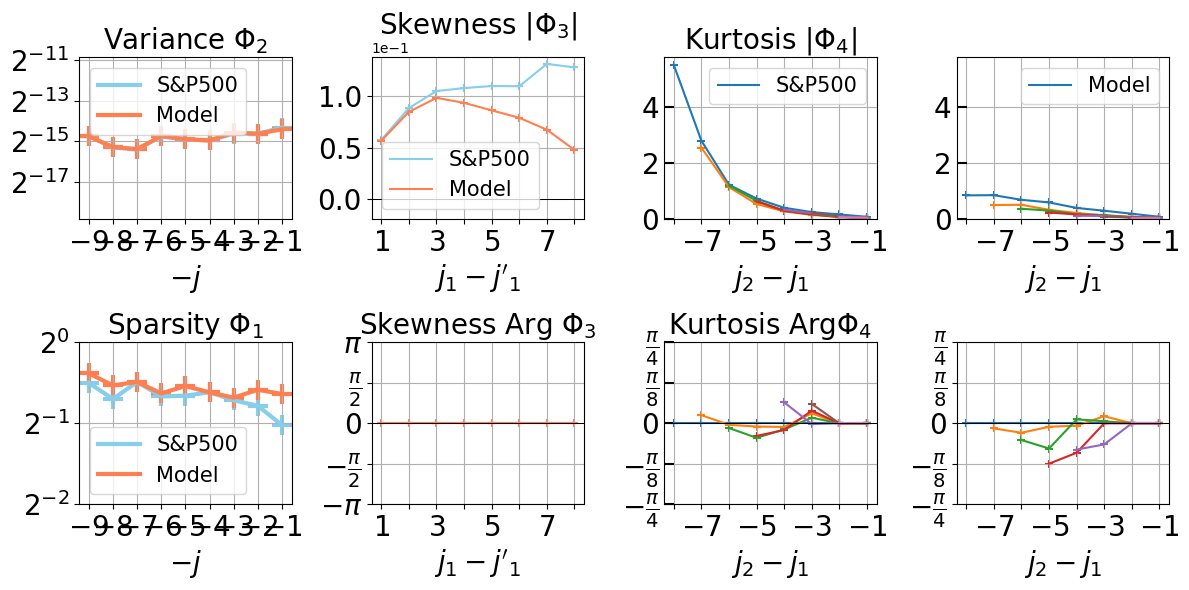

In [12]:
# large tol_optim -> mismatch in the statistics 

# observed data
data_snp = SPDaily()

# generate data
gen_data = generate(
    x=data_snp,
    cuda=CUDA,
    tol_optim=5e-2,
)

# plot time-series
fig, axes = plt.subplots(2, 1, figsize=(10, 3))
axes[0].set_title("Financial log-returns", fontsize=20)
axes[0].plot(data_snp.dts[:-1], data_snp.dlnx[0, 0, :], lw=0.4, color="black")
axes[0].set_ylabel(f"S&P", fontsize=15)
axes[1].plot(data_snp.dts[:-1], gen_data.dlnx[0, 0, :], lw=0.4, color="black")
axes[1].set_ylabel(f"Model", fontsize=15)
for iax, ax in enumerate(axes):
    if iax < axes.size - 1:
        ax.set_xticklabels([])
    ylim = 0.04
    ax.set_ylim(-ylim, ylim)
    ax.grid(True)
    ax.set_yticklabels([])

# plot statistics
scat_snp = analyze(data_snp.dlnx)
scat_gen = analyze(gen_data.dlnx)
plot_dashboard([scat_snp, scat_gen], labels=["S&P500", "Model"], figsize=(12, 6), theta_threshold=[0.3, 0.1]);

Initialize model
Model scat_spectra based on 239 statistics: 
 ---- mean : 1
 ---- spars : 9
 ---- variance : 10
 ---- skewness : 54
 ---- kurtosis : 165
Preparing target statistics
     2it in 0:00:00.11 ( 18.01 it/s ) .... err 1.98E-01
    18it in 0:00:00.52 ( 34.77 it/s ) .... err 9.19E-02
    88it in 0:00:02.29 ( 38.36 it/s ) .... err 2.24E-02
   311it in 0:00:07.96 ( 39.05 it/s ) .... err 3.35E-03
   944it in 0:00:24.10 ( 39.18 it/s ) .... err 4.84E-04
  1945it in 0:00:42.43 ( 45.84 it/s ) .... err 1.28E-04
  2275it in 0:00:48.26 ( 47.14 it/s ) .... err 9.36E-05
  3276it in 0:01:06.27 ( 49.43 it/s ) .... err 6.02E-05
Optimization Exit Message : SmallEnoughException
matched statistics in 78.61s, 3966 iterations -- 50.45it/s
    abs sqrt error 5.00E-05
    relative gradient error 6.28E-07
    loss0 1.63E-01


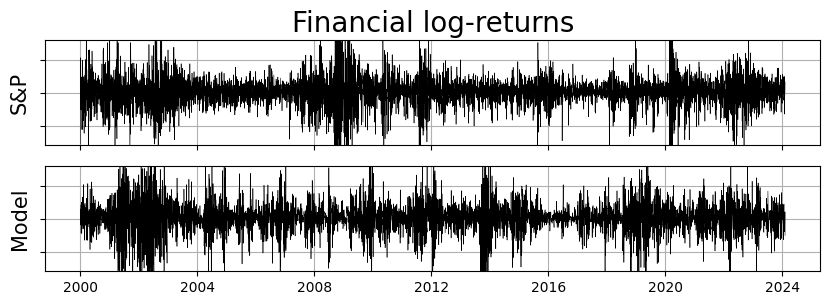

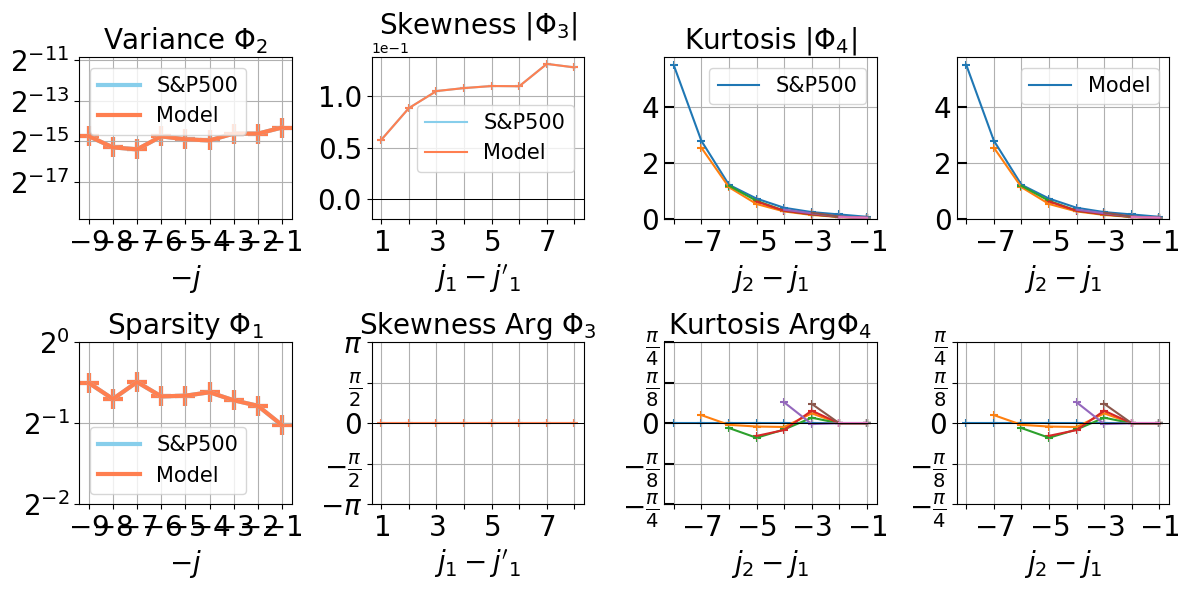

In [13]:
# small tol_optim -> optimization takes time to converge, 
# statistics matched exactly which implies they match the variance of estimation
# which should be avoided

# observed data
data_snp = SPDaily()

# generate data
gen_data = generate(
    x=data_snp,
    max_iterations=10000,
    tol_optim=5e-5,
    cuda=CUDA,
)

# plot time-series
fig, axes = plt.subplots(2, 1, figsize=(10, 3))
axes[0].set_title("Financial log-returns", fontsize=20)
axes[0].plot(data_snp.dts[:-1], data_snp.dlnx[0, 0, :], lw=0.4, color="black")
axes[0].set_ylabel(f"S&P", fontsize=15)
axes[1].plot(data_snp.dts[:-1], gen_data.dlnx[0, 0, :], lw=0.4, color="black")
axes[1].set_ylabel(f"Model", fontsize=15)
for iax, ax in enumerate(axes):
    if iax < axes.size - 1:
        ax.set_xticklabels([])
    ylim = 0.04
    ax.set_ylim(-ylim, ylim)
    ax.grid(True)
    ax.set_yticklabels([])

# plot statistics
scat_snp = analyze(data_snp.dlnx)
scat_gen = analyze(gen_data.dlnx)
plot_dashboard([scat_snp, scat_gen], labels=["S&P500", "Model"], figsize=(12, 6), theta_threshold=[0.3, 0.1]);

Initialize model
Model scat_spectra based on 239 statistics: 
 ---- mean : 1
 ---- spars : 9
 ---- variance : 10
 ---- skewness : 54
 ---- kurtosis : 165
Preparing target statistics
     4it in 0:00:00.18 ( 21.92 it/s ) .... err 1.94E-01
    12it in 0:00:00.40 ( 30.23 it/s ) .... err 1.08E-01
    94it in 0:00:02.45 ( 38.34 it/s ) .... err 2.13E-02
Optimization Exit Message : SmallEnoughException
matched statistics in 5.47s, 212 iterations -- 38.79it/s
    abs sqrt error 5.95E-03
    relative gradient error 3.20E-04
    loss0 2.65E-01


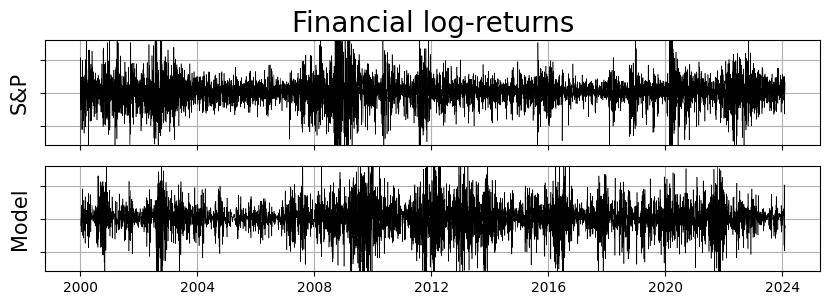

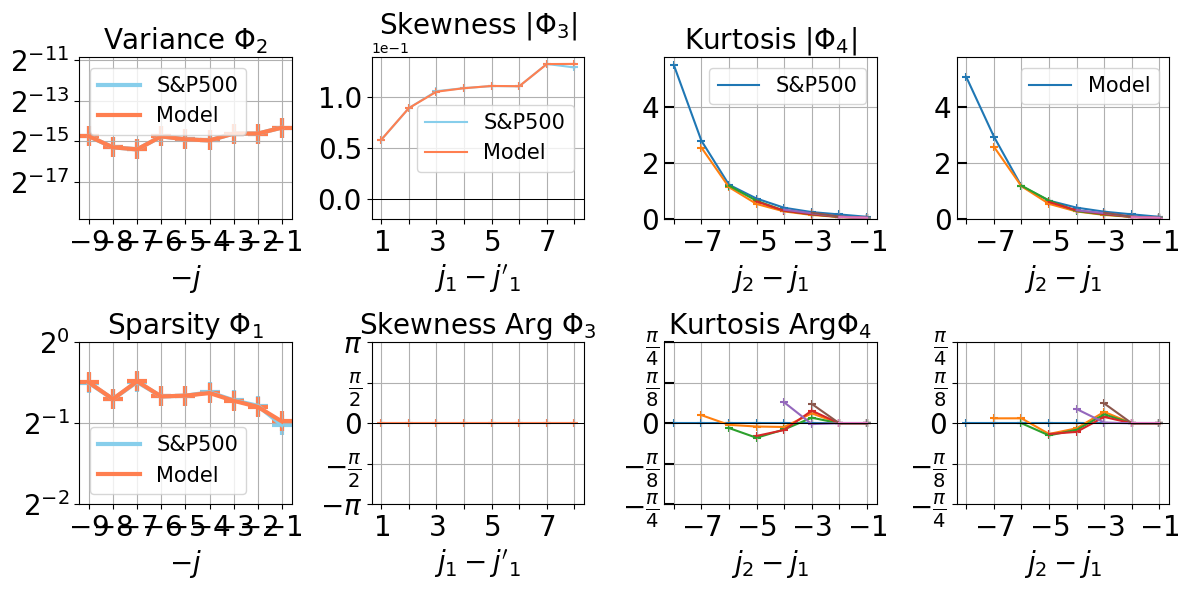

In [14]:
# correct tol_optim -> number of iterations ~100, statistics match well but not exactly, 

# observed data
data_snp = SPDaily()

# generate data
gen_data = generate(
    x=data_snp,
    tol_optim=6e-3,
    cuda=CUDA,
)

# plot time-series
fig, axes = plt.subplots(2, 1, figsize=(10, 3))
axes[0].set_title("Financial log-returns", fontsize=20)
axes[0].plot(data_snp.dts[:-1], data_snp.dlnx[0, 0, :], lw=0.4, color="black")
axes[0].set_ylabel(f"S&P", fontsize=15)
axes[1].plot(data_snp.dts[:-1], gen_data.dlnx[0, 0, :], lw=0.4, color="black")
axes[1].set_ylabel(f"Model", fontsize=15)
for iax, ax in enumerate(axes):
    if iax < axes.size - 1:
        ax.set_xticklabels([])
    ylim = 0.04
    ax.set_ylim(-ylim, ylim)
    ax.grid(True)
    ax.set_yticklabels([])

# plot statistics
scat_snp = analyze(data_snp.dlnx)
scat_gen = analyze(gen_data.dlnx)
plot_dashboard([scat_snp, scat_gen], labels=["S&P500", "Model"], figsize=(12, 6), theta_threshold=[0.3, 0.1]);

## some validations statistics

File validation.py provides standard validation statistics to assess the 
quality of a model.

Here we show the histograms, structure functions, leverage (order 2 moment), which are fast to compute. \
Please also check for other statistics, such as the average smile.

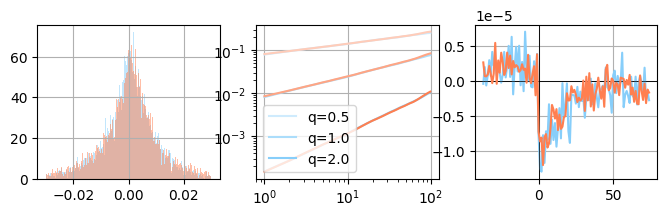

In [15]:
from scatspectra.validation import Histogram, StructureFunctions, Leverage

# statistical validation
fig, axes = plt.subplots(1, 3, figsize=(8,2))

# histogram
stat_calc = Histogram(nbins=200, left=-0.03, right=0.03)
stat_snp = stat_calc.compute(data_snp)
stat_model = stat_calc.compute(gen_data)
stat_calc.plot(*stat_snp, axes[0], color='lightskyblue')
stat_calc.plot(*stat_model, axes[0], color='coral')

# structure functions
stat_calc = StructureFunctions(max_lag=100, qs=[0.5,1.0,2.0], normalize=False)
stat_snp = stat_calc.compute(data_snp)
stat_model = stat_calc.compute(gen_data)
stat_calc.plot(*stat_snp, axes[1], color='lightskyblue')
stat_calc.plot(*stat_model, axes[1], color='coral');

# leverage 
stat_calc = Leverage(max_lag=75)  # order 2 moment: E{dx|dx|}
stat_snp = stat_calc.compute(data_snp)
stat_model = stat_calc.compute(gen_data)
stat_calc.plot(*stat_snp, axes[2], color='lightskyblue')
stat_calc.plot(*stat_model, axes[2], color='coral');

## Influence of coefficients in the model

In [16]:
# observed data
data_snp = SPDaily()

x0 = np.random.randn(*data_snp.dlnx.shape)[:, None, :, :]

# generate data with restricted model
# the model associated to this generation imposes only the 'mean' and
# the 'variance' coefficients (power-spectrum) it is thus a Gaussian model
gen1 = generate(
    x=data_snp,
    x0=x0,
    R=1,
    model_type="scat_spectra",
    coeff_types=["mean", "variance"],
    cache_path=None,
    cuda=CUDA,
)

# generate data with restricted model
# this model is non-Gaussian but does not capture long-range dependencies well
gen2 = generate(
    x=data_snp,
    x0=x0,
    R=1,
    model_type="scat_spectra",
    coeff_types=["mean", "variance", "spars"],
    cache_path=None,
    cuda=CUDA,
)

# generate data with full model
gen_full = generate(
    x=data_snp,
    x0=x0,
    R=1,
    model_type="scat_spectra",
    cache_path=None,
    max_iterations=5000,
    cuda=CUDA,
)

Initialize model
Model scat_spectra based on 11 statistics: 
 ---- mean : 1
 ---- spars : 0
 ---- variance : 10
 ---- skewness : 0
 ---- kurtosis : 0
Preparing target statistics
     4it in 0:00:00.11 ( 36.91 it/s ) .... err 4.50E+03
    10it in 0:00:00.26 ( 38.91 it/s ) .... err 9.88E+02
    15it in 0:00:00.38 ( 39.32 it/s ) .... err 2.03E+02
    23it in 0:00:00.58 ( 39.94 it/s ) .... err 2.99E+01
    27it in 0:00:00.70 ( 38.64 it/s ) .... err 9.37E+00
    36it in 0:00:00.94 ( 38.26 it/s ) .... err 1.41E+00
    44it in 0:00:01.19 ( 36.95 it/s ) .... err 3.50E-01
    61it in 0:00:01.64 ( 37.30 it/s ) .... err 3.04E-02
    73it in 0:00:01.97 ( 37.00 it/s ) .... err 2.72E-03
Optimization Exit Message : SmallEnoughException
matched statistics in 2.11s, 77 iterations -- 36.56it/s
    abs sqrt error 8.63E-04
    relative gradient error 3.37E-04
    loss0 8.64E+03
Initialize model
Model scat_spectra based on 20 statistics: 
 ---- mean : 1
 ---- spars : 9
 ---- variance : 10
 ---- skewness : 

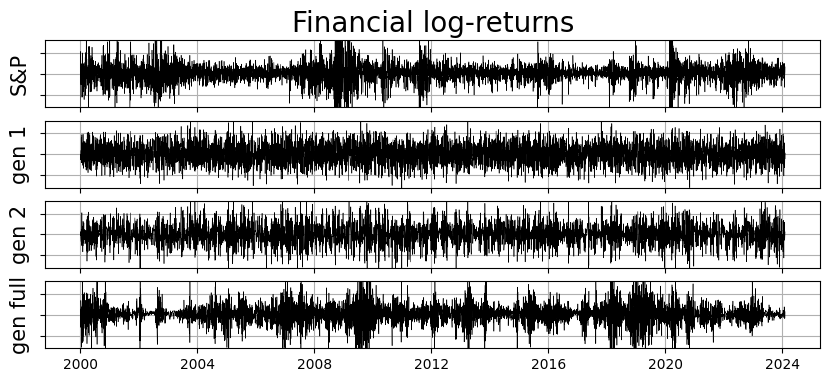

In [17]:
fig, axes = plt.subplots(4, 1, figsize=(10, 4))
axes[0].set_title("Financial log-returns", fontsize=20)
axes[0].plot(data_snp.dts[:-1], data_snp.dlnx[0, 0, :], lw=0.4, color="black")
axes[0].set_ylabel(f"S&P", fontsize=15)
axes[1].plot(data_snp.dts[:-1], gen1.dlnx[0, 0, :], lw=0.4, color="black")
axes[1].set_ylabel(f"gen 1", fontsize=15)
axes[2].plot(data_snp.dts[:-1], gen2.dlnx[0, 0, :], lw=0.4, color="black")
axes[2].set_ylabel(f"gen 2", fontsize=15)
axes[3].plot(data_snp.dts[:-1], gen_full.dlnx[0, 0, :], lw=0.4, color="black")
axes[3].set_ylabel(f"gen full", fontsize=15)
for iax, ax in enumerate(axes):
    if iax < axes.size - 1:
        ax.set_xticklabels([])
    ylim = 0.04
    ax.set_ylim(-ylim, ylim)
    ax.grid(True)
    ax.set_yticklabels([])

## Generation from adjusted representation

[1.0, 0.8, 0.6]


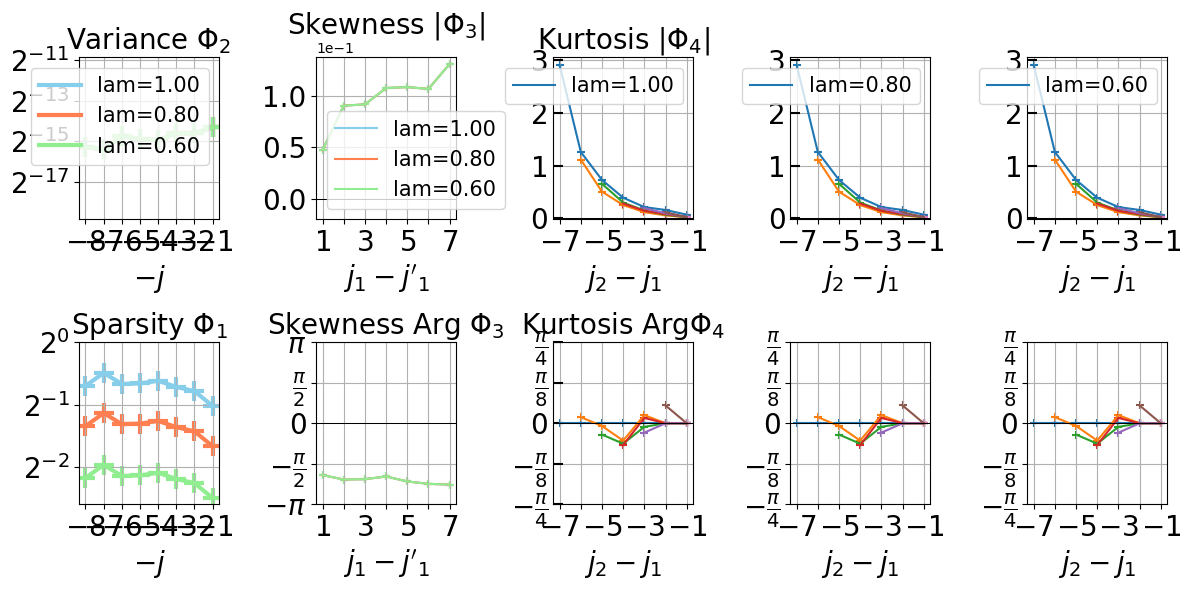

In [3]:
# observed data
data_snp = SPDaily()

# estimate Scattering Spectra on observed data
scat_snp = analyze(x=data_snp.dlnx, model_type="scat_spectra", J=8, cuda=CUDA)

# reference Scattering Spectra of white noise
scat_ref = analyze(
    x=np.random.randn(128, 1, data_snp.dlnx.shape[-1]),
    model_type="scat_spectra",
    J=8,
    cuda=CUDA,
).mean_batch()


def adjust_gaussianity(scat, scat_ref, lam=0.5):
    scat_adj = scat.clone()
    mask = scat_adj.eval("coeff_type=='spars'")
    # scat_adj.y[:,mask,:] = ((1 - lam) * scat_ref.y + lam * scat.y)[:,mask,:]
    scat_adj.y[:, mask, :] = lam * scat.y[:, mask, :]
    return scat_adj


# change the estimated statistics e.g. change sparsity levels
lams = [1.0, 0.8, 0.6]
print(lams)
scats_adjusted = [adjust_gaussianity(scat_snp, scat_ref, lam) for lam in lams]

axes = plot_dashboard(
    scats_adjusted, labels=[f"lam={lam:.2f}" for lam in lams], figsize=(12, 6)
)
axes[1, 0].legend().remove()

In [4]:
# start from the same gaussian white noise
x0 = np.random.randn(*data_snp.dlnx.shape)[:,None,:,:]

# generate data based on the adjusted statistics
gen_adjusted = []
for ilam, scat_adj in enumerate(scats_adjusted):
    gen = generate(
        Rx=scat_adj,
        x0=x0,
        gen_length=data_snp.dlnx.shape[-1],
        model_type="scat_spectra",
        J=8,
        cuda=CUDA,
    )
    gen_adjusted.append(gen)


Initialize model
Model scat_spectra based on 182 statistics: 
 ---- mean : 1
 ---- spars : 8
 ---- variance : 9
 ---- skewness : 44
 ---- kurtosis : 120
     4it in 0:00:00.11 ( 36.43 it/s ) .... err 3.74E+03
     9it in 0:00:00.22 ( 40.09 it/s ) .... err 1.17E+03
    16it in 0:00:00.38 ( 41.59 it/s ) .... err 2.14E+02
    23it in 0:00:00.54 ( 42.29 it/s ) .... err 4.45E+01
    30it in 0:00:00.70 ( 42.58 it/s ) .... err 8.52E+00
    37it in 0:00:00.87 ( 42.70 it/s ) .... err 1.53E+00
    42it in 0:00:01.02 ( 41.24 it/s ) .... err 4.76E-01
    54it in 0:00:01.31 ( 41.14 it/s ) .... err 8.75E-02
   113it in 0:00:02.73 ( 41.34 it/s ) .... err 2.59E-02
   280it in 0:00:06.82 ( 41.04 it/s ) .... err 4.05E-03
Optimization Exit Message : SmallEnoughException
matched statistics in 12.66s, 519 iterations -- 41.01it/s
    abs sqrt error 9.94E-04
    relative gradient error 5.24E-05
    loss0 4.02E+03
Initialize model
Model scat_spectra based on 182 statistics: 
 ---- mean : 1
 ---- spars : 8
 --

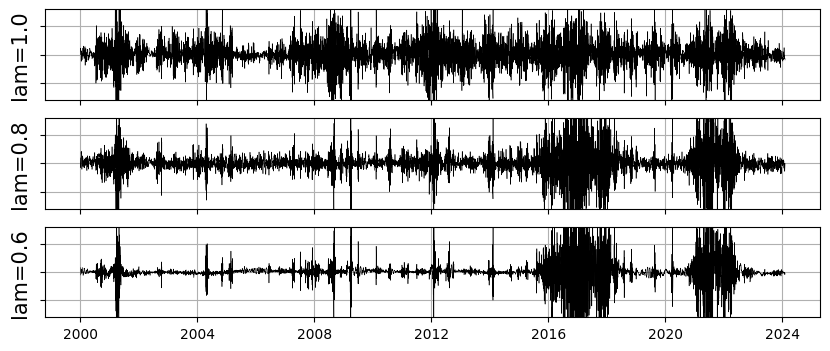

In [5]:
#
fig, axes = plt.subplots(len(gen_adjusted), 1, figsize=(10, 4))
for iax, x_gen_adj in enumerate(gen_adjusted):
    axes[iax].plot(data_snp.dts[:-1], x_gen_adj.dlnx[0, 0, :], lw=0.4, color="black")
    axes[iax].set_ylabel(f"lam={lams[iax]}", fontsize=15)
for iax, ax in enumerate(axes):
    if iax < axes.size - 1:
        ax.set_xticklabels([])
    ylim = 0.04
    ax.set_ylim(-ylim, ylim)
    ax.grid(True)
    ax.set_yticklabels([])

## multi-variate time-series

WARNING: the multivariate model was not studied into detail. \
The code implements a naive extension of the Scattering Spectra which \
number of coefficients scale in N^2 with N the number of time-series. 

In [19]:
# observed data
data_snpvix = SPVIXDaily()

# generate data
gen_data = generate(
    x=data_snpvix,
    R=1,  # number of realizations to generate 
    model_type="scat_spectra",
    gen_log_returns=False,
    multivariate_model=True,  # activate the multi-variate model
    tol_optim=9e-3,
    cache_path=None,  # provide a directory if you want to cache the generations
    cuda=CUDA,  # you are strongly encouraged to use GPU if available
)

Initialize model
Model scat_spectra based on 936 statistics: 
 ---- mean : 2
 ---- spars : 18
 ---- variance : 40
 ---- skewness : 216
 ---- kurtosis : 660
Preparing target statistics
    31it in 0:00:00.94 ( 33.03 it/s ) .... err 1.09E-01
   119it in 0:00:03.69 ( 32.25 it/s ) .... err 2.68E-02
Optimization Exit Message : SmallEnoughException
matched statistics in 9.71s, 313 iterations -- 32.23it/s
    abs sqrt error 8.99E-03
    relative gradient error 1.93E-05
    loss0 3.04E-01


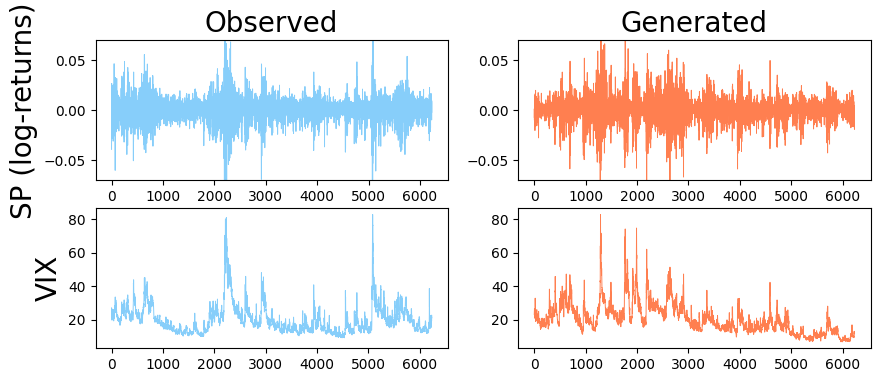

In [20]:
from scatspectra.utils import set_same_lim

fig, axes = plt.subplots(2,2, figsize=(10,4))
axes[0,0].plot(data_snpvix.dlnx[0,0,:], color='lightskyblue', lw=0.7);
axes[1,0].plot(data_snpvix.x[0,1,:], color='lightskyblue', lw=0.7);
axes[0,1].plot(gen_data.dlnx[0,0,:], color='coral', lw=0.7);
axes[1,1].plot(gen_data.x[0,1,:], color='coral', lw=0.7);
for ax in axes[0,:]:
    ax.set_ylim(-0.07,0.07)
set_same_lim(*axes[0,:], axis='both')
set_same_lim(*axes[1,:], axis='both')
axes[0,0].set_ylabel('SP (log-returns)', fontsize=20)
axes[1,0].set_ylabel('VIX', fontsize=20)
axes[0,0].set_title('Observed', fontsize=20)
axes[0,1].set_title('Generated', fontsize=20);
